In [1]:
%pip install scikit-learn scikit-lego

     |████████████████████████████████| 223 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 7.9 MB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 8.2 MB/s  eta 0:00:01
     |████████████████████████████████| 88 kB 9.5 MB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 8.2 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82820 sha256=c316b9b496924ba5ce69ea2a8470319d257709295090ba3eae90021003e27a15
  Stored in directory: /Users/thewatchman/Library/Caches/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53931 sha256=783e35d449de29426ef22e85f6f77892d98b7f9c3b471fe6ae07a9ed4c82f7a2
  Stored in directory: /Users/thewatchman/Library/Caches/pip/wheels/1d/07/6e/9ae4e883392994fd1d7c61a0377f0177e3f8e2faff6c677341
Successfully built umap-learn pynndescent
  Attempting uninstall: scikit-learn
    Fou

***Voting Classifier***

In [45]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=2000, n_features=2,
                           n_redundant=0, random_state=21,
                           class_sep=1.75, flip_y=0.1)

#plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [46]:
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");
    

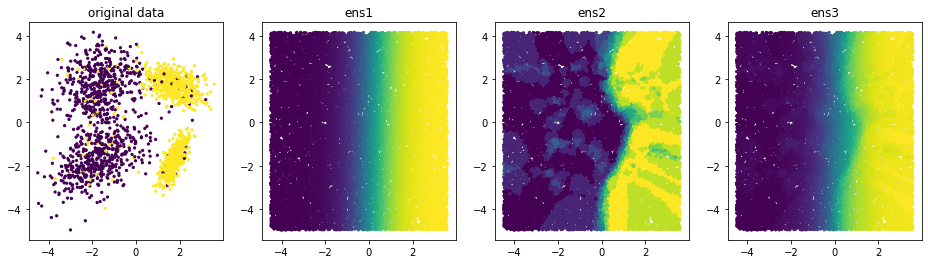

In [48]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)],
                       voting='soft',
                       weights=[10.5, 2.5]) 
#                       weights=[0.5, 0.5])
clf3.fit(X, y)

make_plots()

***Threshold***

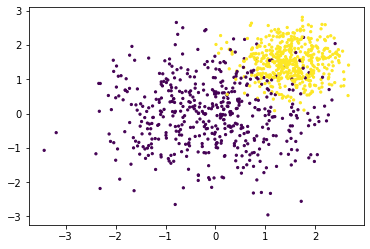

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego.meta import Thresholder
X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)

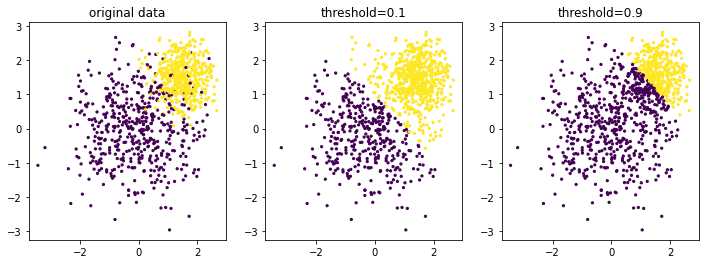

In [27]:
m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X, y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X, y)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");


In [ ]:
pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                  param_grid = {"model_threshold": np.linspace(0.1, 0.9, 50)},
                  scoring={"precision": make_scorer(precision_score),
                          "recall": make_scorer(recall_score),
                          "accuracy": make_scorer(accuracy_score)},
                  refit="precision",
                  cv=5)

mod.fit(X, y);

***Grouped Models***

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(as_frame=True)

def plot_model(model):
    df = load_chicken(as_frame=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    #plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per ground, MAE: {np.round(metric, 2)}");
    

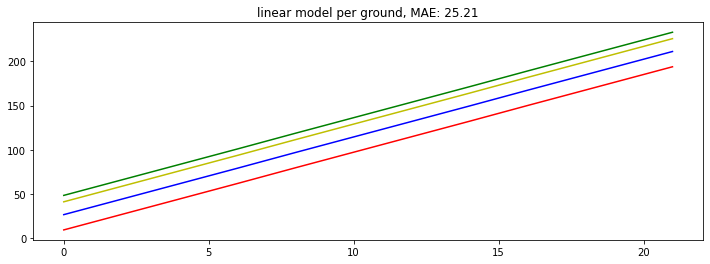

In [30]:
feature_pipeline = Pipeline([ 
    ("datagrab", FeatureUnion([
        ("discrete", Pipeline([
            ("grab", ColumnSelector("diet")),
            ("encode", OneHotEncoder(categories="auto", sparse=False))
        ])),
        ("continuous", Pipeline([
            ("grab", ColumnSelector("time")),
            ("standardize", StandardScaler())
        ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", LinearRegression())
])

plot_model(pipe)

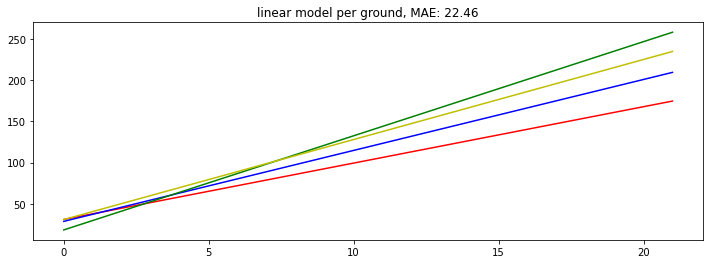

In [31]:
from sklego.meta import GroupedPredictor
mod = GroupedPredictor(LinearRegression(), groups=["diet"])
plot_model(mod)

***Zero Inflated Regression***

In [32]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklego.meta import ZeroInflatedRegressor

#
#
df = (pd.DataFrame({'dt': pd.date_range("2018-01-01", "2021-01-01")})
     .assign(x=lambda d: np.random.normal(0, 1, d.shape[0]))
     .assign(weekend = lambda d: (d['dt'].dt.weekday >= 5).astype(np.int16))
     .assign(y=lambda d: np.where(d['weekend'], 0, 1.5 + 0.87 * d['x'] + np.random.normal(0, 0.2, d.shape[0]))))

In [ ]:
X, y = df[['x', 'weekend']].values, df['y'].values

In [37]:
zir = ZeroInflatedRegressor(
    classifier=LogisticRegression(),
    regressor=Ridge()
)

lr = Ridge(random_state = 0)

print('ZIR r^2:', cross_val_score(zir, X, y).mean())
print(' LR r^2:', cross_val_score(lr, X, y).mean())

ZIR r^2: 0.7533728432461706
 LR r^2: 0.6491346984884961


***Decay***

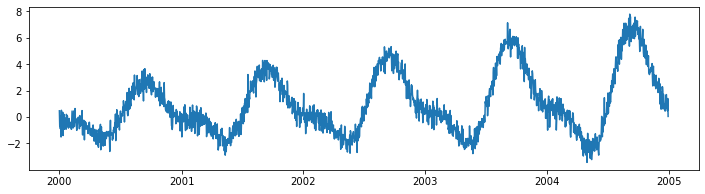

In [50]:
from sklearn.dummy import DummyRegressor
from sklego.meta import GroupedPredictor, DecayEstimator
from sklego.datasets import make_simpleseries
import matplotlib.pylab as plt

yt = make_simpleseries(seed=1)
dates = pd.date_range("2000-01-01", periods=len(yt))
df = (pd.DataFrame({"yt": yt, 
                   "date": dates})
     .assign(m=lambda d: d.date.dt.month)
     .reset_index())

plt.figure(figsize=(12,3))
plt.plot(dates, make_simpleseries(seed=1))
plt.savefig('time_series_initial.png');

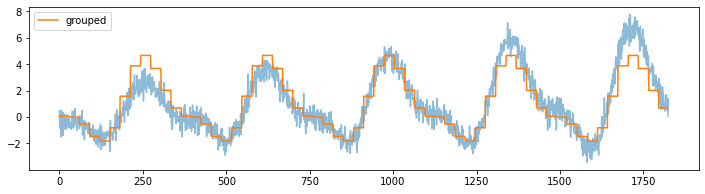

In [51]:
mod1 = (GroupedPredictor(DummyRegressor(), groups=['m'])
       .fit(df[['m']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.legend()
plt.savefig('time_series_grouped.png');

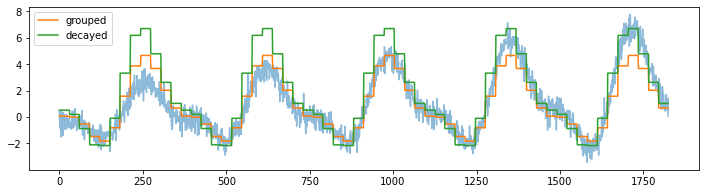

In [53]:
mod1 = (GroupedPredictor(DummyRegressor(), groups=['m'])
       .fit(df[['m']], df['yt']))

mod2 = (GroupedPredictor(DecayEstimator(DummyRegressor(), decay = 0.9), groups=["m"])
       .fit(df[['index', 'm']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.plot(mod2.predict(df[['index', 'm']]), label="decayed")
plt.legend()
plt.savefig('time_series_grouped_and_decayed.png');